# Pogona Notebook

In [20]:
from Detector.detector import Detector_v4, Detector_v3
from PIL import Image
import torch
from torchvision import transforms
import Detector.visualize as visualize
import re
import glob
import os
import numpy as np
import imp
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [22]:
detector = Detector_v4(weights_path='Detector/Yolo4/yolo4_gs_best_2306.weights',
                      cfg_path='Detector/Yolo4/yolo4_2306.cfg')

Detector initiated successfully


In [23]:
detector.set_input_size(1440,1080)

## Save prediction video

In [13]:
NUM_FRAMES = 3000
test_video_path = "./Arena/output/20200615-181757/19506481.avi"
times,centroids = visualize.save_pred_video(test_video_path, 
                              "labelled/1506_181757_dots_wght2306.mp4", 
                              detector,num_frames=NUM_FRAMES, 
                              visAngle=True,
                              dots=True,
                              arrowWindow=240)

  0%|          | 3/3000 [00:00<01:41, 29.47it/s]

saving to:  labelled/1506_181757_dots_wght2306.mp4
width: 1440, height: 1080


100%|██████████| 3000/3000 [01:21<00:00, 37.01it/s]

Read: 4.83 ms
Rsz_inf: 13.64 ms
Write: 7.31 ms


Read :  207.0
Rsz_inf :  73.0
Write :  137.0
Average FPS:  39.0


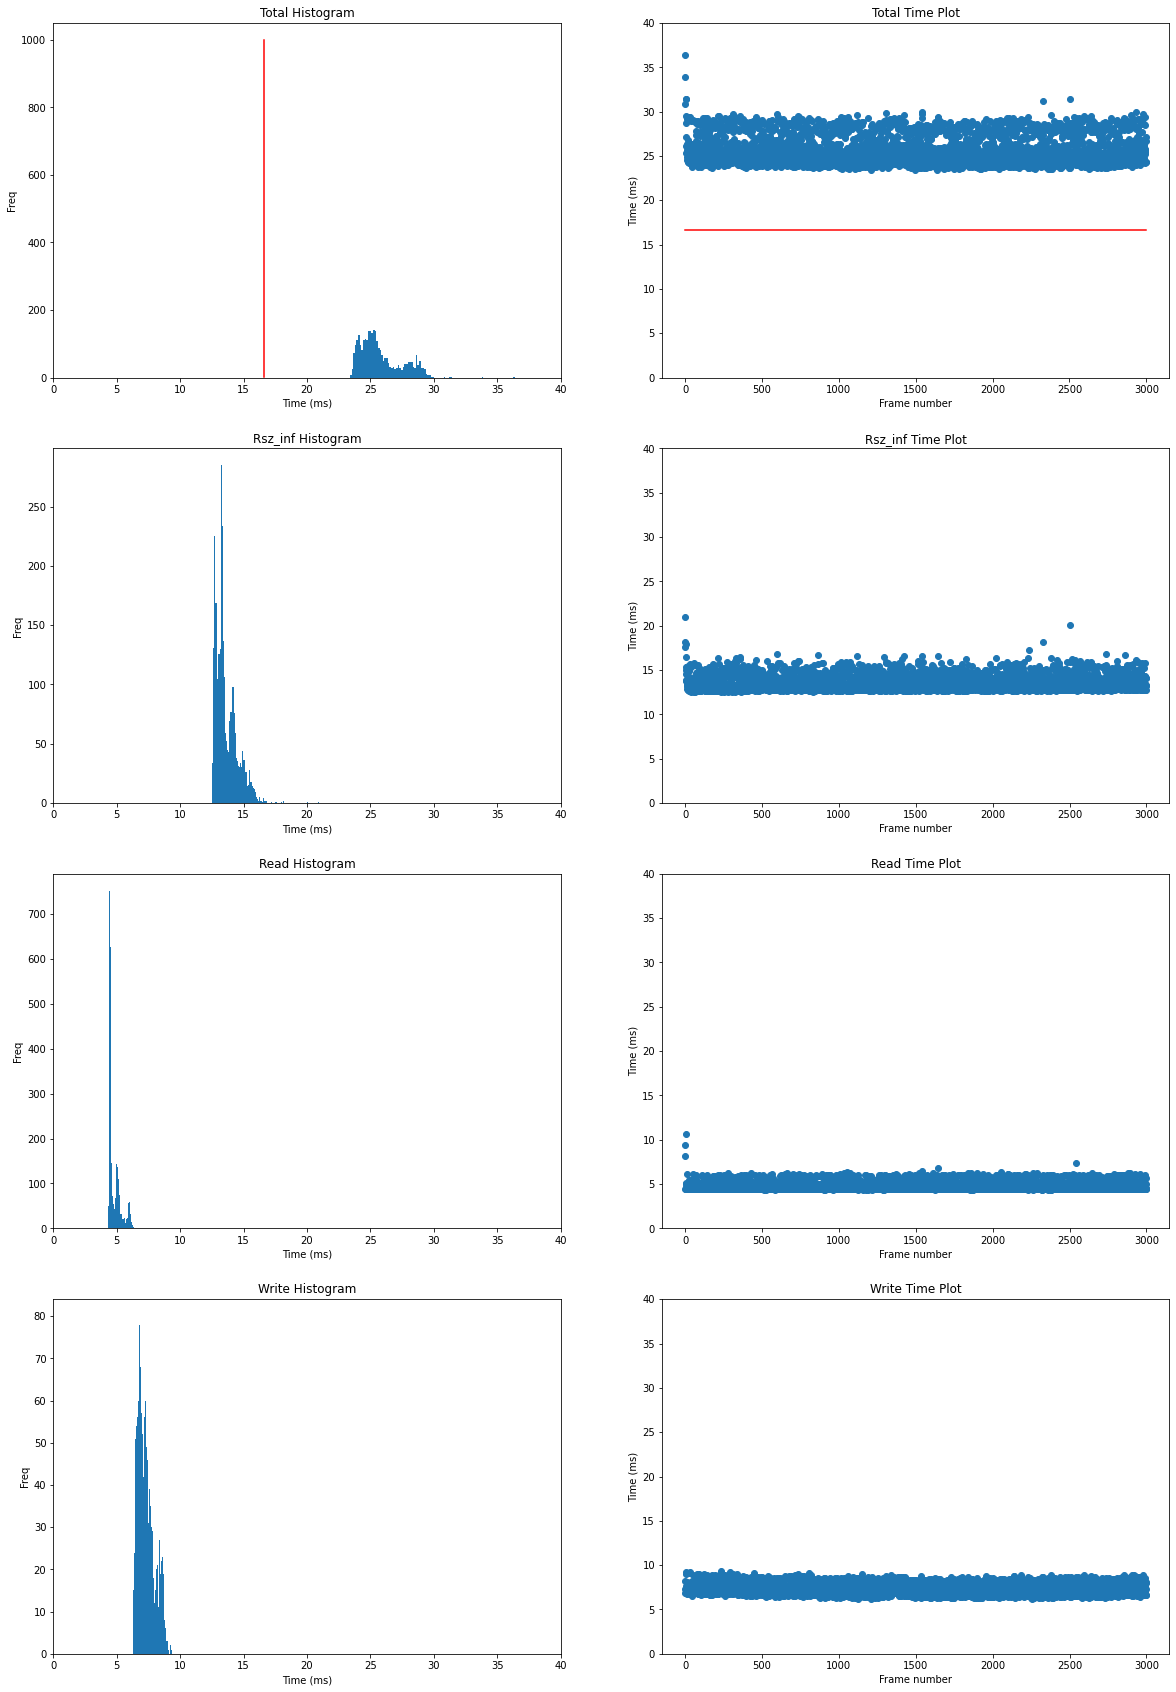

In [15]:
# analyzq timings

XLIM=40
YLIM=40

TOTAL_XLIM = 80
TOTAL_YLIM = 80

centros = centroids[:,:2]
speed = visualize.compute_velocity(centros)

confs = centroids[:,2]
for k in times.keys():
    print(k,": ",round(1/times[k].mean()))
times['Total'] = np.sum(np.stack([times[k] for k in times.keys() if k!='Total'],axis=1),axis=1)
print("Average FPS: ",round(1/times['Total'].mean()))



phases = ['Rsz_inf','Read','Write'] # sorted order
fig,axs = plt.subplots(len(phases)+1,2,figsize=(20,30))
k='Total'
axs[0][0].set_title(k+' Histogram')
axs[0][1].set_title(k+' Time Plot')
axs[0][0].hist(times[k]*1000,label=k,bins=100)
axs[0][0].set_xlim(0,XLIM)
axs[0][0].set_xlabel('Time (ms)')
axs[0][1].set_xlabel('Frame number')
axs[0][0].set_ylabel('Freq')
axs[0][1].set_ylabel('Time (ms)')
axs[0][1].scatter(np.arange(times[k].shape[0]),times[k]*1000)
axs[0][1].set_ylim(0,YLIM)
axs[0][0].plot(np.ones(5)*16.6,np.linspace(1,1000,5),color='r')
axs[0][1].plot(np.linspace(1,3000,5),np.ones(5)*16.6,color='r')
for i,k in enumerate(phases):
    i+=1
    axs[i][0].set_title(k+' Histogram')
    axs[i][1].set_title(k+' Time Plot')
    axs[i][0].hist(times[k]*1000,label=k,bins=100)
    axs[i][0].set_xlim(0,XLIM)
    axs[i][0].set_xlabel('Time (ms)')
    axs[i][1].set_xlabel('Frame number')
    axs[i][0].set_ylabel('Freq')
    axs[i][1].set_ylabel('Time (ms)')
    axs[i][1].scatter(np.arange(times[k].shape[0]),times[k]*1000)
    axs[i][1].set_ylim(0,YLIM)
#plt.savefig('timings.jpg')

## Plot with figure on video with centroids

In [19]:
%matplotlib agg
#imp.reload(visualize)
#test_video_path = "./Arena/output/20200615-175044/19506481.avi"
visualize.plot_with_figure(input_name=test_video_path,
                           output_name='labelled/1506_181757_2306_figure.mp4',
                           centroids=centroids,
                           num_frames=1000)

  0%|          | 2/1000 [00:00<01:04, 15.57it/s]

width: 1440, height: 1080


100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]


## Save missed frames

In [3]:
test_video_path = "/media/sil2/regev/pose_estimation/Arena/output/20200521-195335/19506481-0000.avi"
vid_name = '19506481-0000.avi'
path_to = '/media/sil2/regev/pose_estimation/Arena/output/20200521'
L = glob.glob(path_to+'*')
video_paths = []
output_paths = []
for file in L:
    vid_time = re.search('20200521-(\d+)',file).group(1)
    p = os.path.join(path_to+'-'+vid_time,vid_name)
    if os.path.exists(p):
        video_paths.append(p)
        output_paths.append("labelled/arrow_" + vid_time + ".mp4")
        
video_paths

['/media/sil2/regev/pose_estimation/Arena/output/20200521-172245/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172519/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172637/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172842/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173206/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173410/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173606/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174011/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174247/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174430/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-175816/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-180046/

In [30]:
for i in range(len(video_paths)):
    if re.search('20200521-(\d+)',video_paths[i]).group(1)[:2]=='17':
        continue
    inf_time = visualize.save_pred_video(video_paths[i], video_paths[i], detector)
    #print("Inference framerate:", 1/inf_time)

NameError: name 'video_paths' is not defined

In [89]:
imp.reload(visualize)

<module 'Detector.visualize' from '/app/Pogona_Pursuit/Detector/visualize.py'>

In [197]:
input_dir = './Arena/output/20200617-'
time = '222733'
vid_path = input_dir+time+'/19506481.avi'
if os.path.exists(vid_path):;
    visualize.save_missed_frames(video_path=vid_path,
                       output_dir='./new_frames_1806_high/',
                       detector=detector,
                       save_thresh=0.98,
                       num_frames=3000,
                       save_max=250,
                       above=True)

  0%|          | 4/3000 [00:00<01:27, 34.17it/s]

saving to:  ./new_frames_1806_high/


  8%|▊         | 240/3000 [00:04<00:53, 51.39it/s]


KeyboardInterrupt: 

## Abaltion study

In [25]:
im_good = cv.imread('test_images/test_high.jpg')
im_none = cv.imread('test_images/test_none.jpg')
im_low = cv.imread('test_images/test_low4.jpg')

In [27]:
%matplotlib inline

Possible cell sizes are [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45, 60, 72, 90, 120, 180, 360]
Please choose cell size from the list:


 45


cells x: 32, cells y: 24, total of 768 iterations. Continue [y/n]?


 y


Rows: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


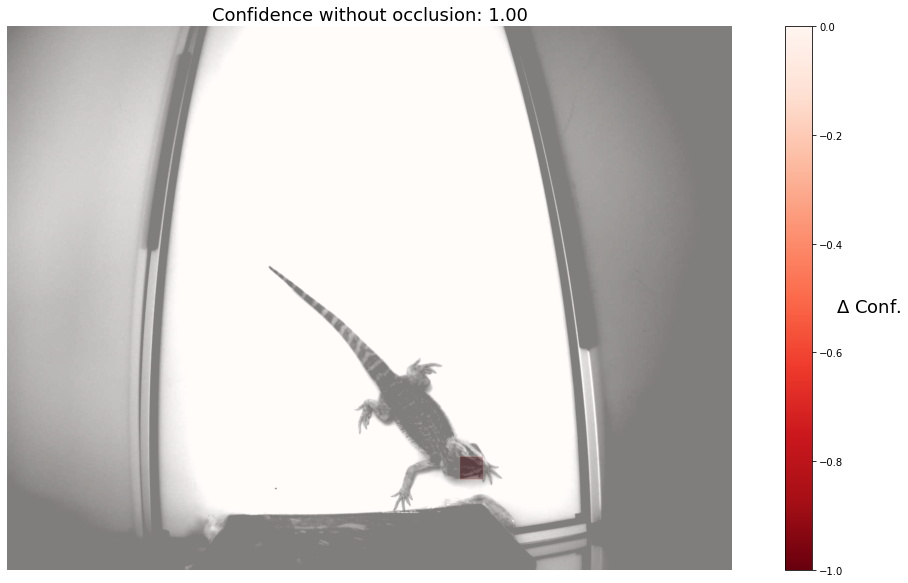

In [39]:
visualize.visualize_ablation_heatmap(im_good,
                                     detector)

Possible cell sizes are [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45, 60, 72, 90, 120, 180, 360]
Please choose cell size from the list:


 72


cells x: 20, cells y: 15, total of 300 iterations. Continue [y/n]?


 y


Rows: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


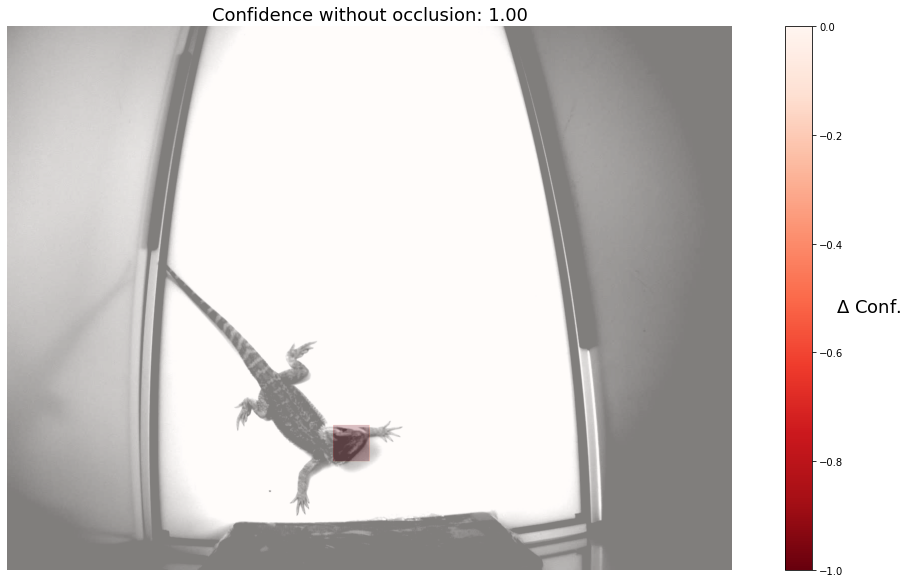

In [43]:
visualize.visualize_ablation_heatmap(im_none,
                                     detector)

Possible cell sizes are [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45, 60, 72, 90, 120, 180, 360]
Please choose cell size from the list:


 45


cells x: 32, cells y: 24, total of 768 iterations. Continue [y/n]?


 y


Rows: 100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


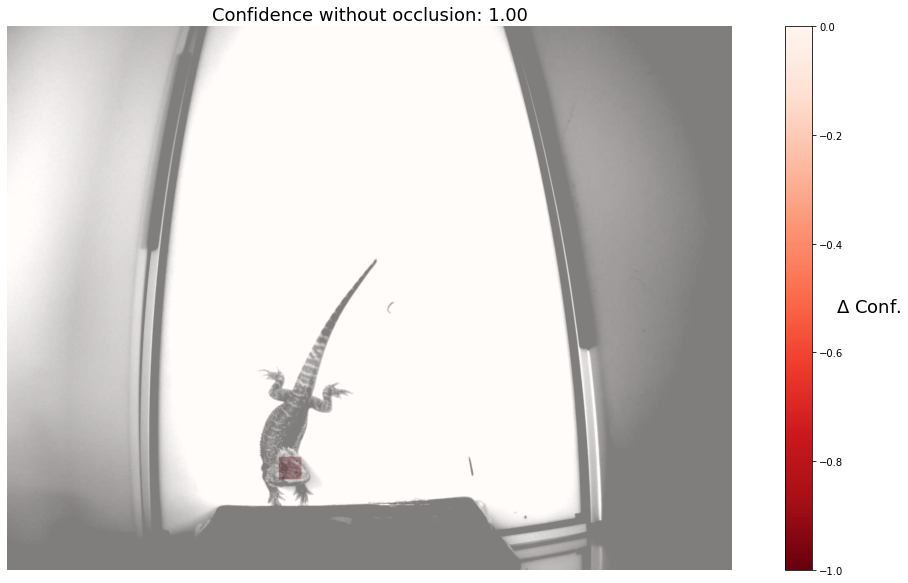

In [36]:
visualize.visualize_ablation_heatmap(im_low,
                                     detector)

For iamges with no or low confidence detection, the ablation may reveal 
what parts of the image cause the detector to fail. 
In the example of test_none.jpg, we can see that if the hand is occluded,
the confidence spikes, so we can deduce that for some reason, this is the part of the inmage
causing the low confidence

In [34]:
im = cv.imread('test_images/test_none_noshadow.jpeg')

In [9]:
detector.set_conf_and_nms(new_conf_thres=0.01)

In [17]:
imgs = os.listdir('/home/user/darknet/data/obj')

In [24]:
d = {'flir_above':0,'flir_non':0,'flir_other':0,'color_lab':0,'color_non':0}
for f in imgs:
    if '.jpg' in f:
        for key in d.keys():
            if key in f:
                d[key]+=1
                break


In [25]:
d


{'flir_above': 1520,
 'flir_non': 562,
 'flir_other': 64,
 'color_lab': 664,
 'color_non': 832}

In [26]:
sum(d.values())

3642